In [270]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

MOVIES_DATA_FILE = os.path.join("data", "movies.csv")
RATINGS_DATA_FILE = os.path.join("data", "ratings.csv")

N_USERS, N_MOVIES = 943, 1682

movies = pd.read_csv(MOVIES_DATA_FILE,
                    #header = None,
                    sep = ",",
                    #names = ["movieId", "title" ,"genres"],
                    dtype = {"movieId": int,
                             "title": str,
                             "genres": str})

ratings = pd.read_csv(RATINGS_DATA_FILE,
                    #header = None,
                    sep = ",",
                    #names = ["userId", "movieId", "rating", "timestamp"],
                    dtype = {"userId": int,

                             "movieId": int,
                             "rating": float,
                             "timestamp": int})

ratings.timestamp = pd.to_datetime(ratings.timestamp, unit = "s")
#userId,movieId,rating,timestamp

column_names = ["movie_id", "movie_title", "video_release", "empty", "URL"] + genres

movies[['movie_title', 'year']] = movies['title'].str.extract(r'^(.*)\s\((\d{4})\)$')
movies.year = movies.year.astype(float)
movies = movies.drop(["title"], axis = 1)

all_genres = sorted(set(genre for genre_list in movies["genres"] for genre in genre_list.split("|")))

for g in all_genres:
    movies[g] = movies["genres"].apply(lambda x: 1 if g in x else 0)

## Distribution of ratings

The half-ratings are less frequent but show the same shape as the whole-number ratings.

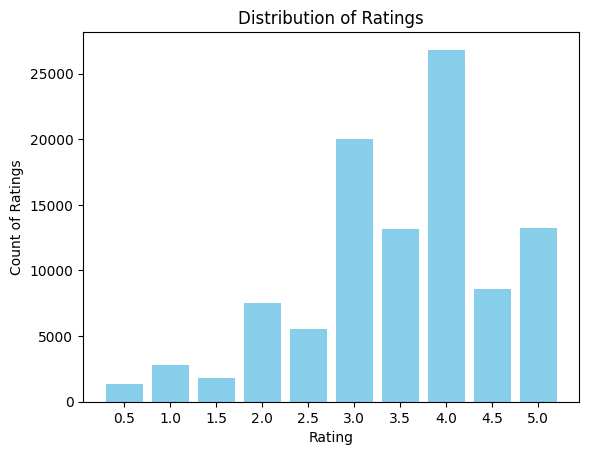

In [271]:
plt.bar(ratings.rating.value_counts().sort_index().index,
        ratings.rating.value_counts().sort_index().values,
        width=0.4,
        align='center',
        color='skyblue')
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Count of Ratings")
plt.xticks([.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]);

## Mean rating by day of week and year

Is there any periodicity in ratings across the week or the year?

There does not seem to be any differences in rating across the days of week or the months of the year.

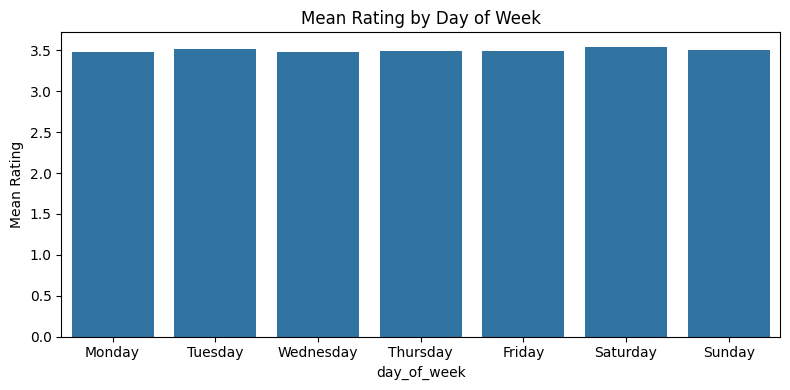

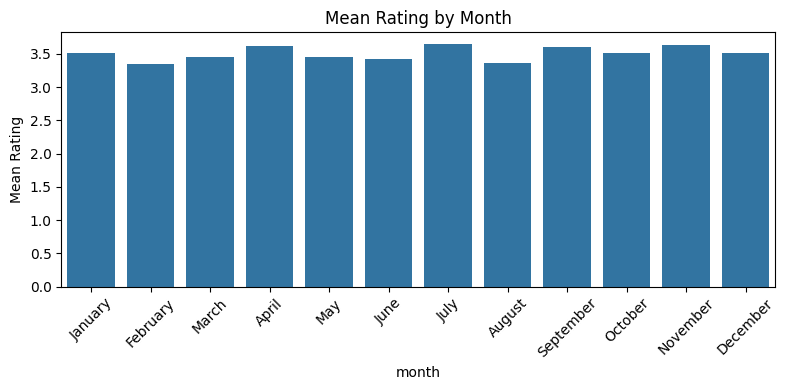

In [272]:
ratings['day_of_week'] = ratings['timestamp'].dt.day_name()
ratings['month'] = ratings['timestamp'].dt.month_name()

weekday = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

avg_by_day = ratings.groupby('day_of_week')['rating'].mean().reindex(weekday)

# Plot
plt.figure(figsize=(8, 4))
sns.barplot(x=avg_by_day.index, y=avg_by_day.values)
plt.title("Mean Rating by Day of Week")
plt.ylabel("Mean Rating")
plt.tight_layout()
plt.show()

months = [
    'January', 'February', 'March', 'April', 'May',
    'June', 'July', 'August', 'September', 'October', 'November', 'December'
]

# Group by month
avg_by_month = ratings.groupby('month')['rating'].mean().reindex(months).dropna()

# Plot
plt.figure(figsize=(8, 4))
sns.barplot(x=avg_by_month.index, y=avg_by_month.values)
plt.title("Mean Rating by Month")
plt.ylabel("Mean Rating")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Find the closest movies to `Toy Story`

We fit a basic LDA model to the genres given in the ratings database. We then find the $5$ most similar items based on the LDA embeddings.

The number of latent factors was determined heuristically.

In [273]:
MOVIE = "Toy Story"
N_COMPONENTS = 8

vectorizer = CountVectorizer(tokenizer = lambda x: x.split("|"),
                             lowercase = False,
                             binary = True,
                             token_pattern = None)

X = vectorizer.fit_transform(movies["genres"])

lda = LatentDirichletAllocation(n_components = N_COMPONENTS,
                                random_state = 1)

lda.fit(X)
topic_distributions = lda.transform(X)

toy_story_index = movies[movies["movie_title"] == MOVIE].index[0]
toy_story_topic = topic_distributions[toy_story_index]

similarities = cosine_similarity([toy_story_topic], topic_distributions)[0]

# Get indices of top 5 recommendations
top_5_indices = np.argsort(similarities)[-5:][::-1]

recommendations = movies.iloc[top_5_indices][['movie_title']]

recommendations['similarity_score'] = similarities[top_5_indices]
print("Top 5 recommendations for a user who has watched 'Toy Story'")
print(recommendations)

Top 5 recommendations for a user who has watched 'Toy Story'
                                           movie_title  similarity_score
0                                            Toy Story               1.0
1706                                              Antz               1.0
3000                         Emperor's New Groove, The               1.0
2355                                       Toy Story 2               1.0
7760  Asterix and the Vikings (Astérix et les Vikings)               1.0
